## Imports


In [1]:
from _params_models import rf_model_params

import io
import sys
import time
import pickle
import sympy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from typing import Tuple
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

## Utility
functions and things that helped the use and modularity of the code

In [2]:
def get_datasets(dataset_name="sinusoid_8h"):
    source_data = dataset_name
    if dataset_name == "mix":
        source_data = "mix_5h"
    if dataset_name == "flashcrowd":
        source_data = "flashcrowd_6h"
    if dataset_name == "sinusoid":
        source_data = "sinusoid_8h"
    data_log = pd.read_csv(f"assets/data/log_INT_{source_data}.txt", delimiter=",")
    data_log.columns = data_log.columns.str.replace(" ", "")
    data_dash = pd.read_csv(f"assets/data/dash_{source_data}.log", sep=",")

    return data_log, data_dash

def remove_useless_attribute(dataset):
    dataset.drop(columns=dataset.columns[dataset.nunique() == 1], inplace=True)
    return dataset

def remove_outlier_IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_final = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))]
    return df_final

def change_NaN_to_mean(dataset):
    dataset = dataset.fillna(dataset.mean())
    return dataset


def normalization(X):
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    return X

def merge_datasert(data_log, data_dash):
    data_log = remove_useless_attribute(data_log)

    data_dash['timestamp'] = data_dash['timestamp'].astype(str).str[:10].astype(int)
    total = data_log.merge(data_dash, on=['timestamp', 'timestamp'], how='left')
   
    total = remove_outlier_IQR(total)
    total = change_NaN_to_mean(total)
    features = total.iloc[:,1:len(data_log.columns)].values
    labels = total['framesDisplayedCalc'].values

    features = normalization(features)

    return features, labels

def visualize_results(feature_importances, feature_names):

    feature_importances_df = pd.DataFrame({
        'Features': feature_names,
        'Importância': feature_importances
    }).sort_values(by='Importância', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importância', y='Features', data=feature_importances_df)
    plt.title('Importância das Features')
    plt.xlabel('Importância')
    plt.ylabel('Features')
    plt.show()

## Models for tranning

In [3]:
def nmae(y_true, y_pred):
    nmae_value = mean_absolute_error(y_true, y_pred) / np.mean(y_true)
    return nmae_value

def default_random_forest_model(
    features: pd.DataFrame, labels: pd.Series, model_params: rf_model_params
):

    X_train, X_validation, y_train, y_validation = train_test_split(
        features,
        labels,
        test_size=model_params.test_size,
        random_state=model_params.random_state,
        shuffle=model_params.shuffle
    )

    X_train_scaled = X_train
    X_validation_scaled = X_validation

    rf_model = RandomForestRegressor(
        n_estimators=model_params.n_estimators,
        max_depth=model_params.max_depth,
        min_samples_split=model_params.min_samples_split,
        min_samples_leaf=model_params.min_samples_leaf,
        bootstrap=model_params.bootstrap,
        verbose=model_params.verbose,
        max_features=model_params.max_features,
        n_jobs=model_params.n_jobs,
        random_state=model_params.random_state,
    )

    mae_scorer = make_scorer(nmae, greater_is_better=False)

    kf = KFold(
        n_splits=model_params.n_splits,
        shuffle=model_params.shuffle,
    )

    cross_val_scores = cross_val_score(
        rf_model, X_train_scaled, y_train, cv=kf, scoring=mae_scorer
    )

    avg_cross_val_score = np.mean(cross_val_scores)

    rf_model.fit(X_train_scaled, y_train)
    
    predictions = rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, predictions)
    nmae_rf = nmae(y_validation, predictions)

    return mae_rf, nmae_rf, rf_model

In [4]:
data_log_sinusoid, data_dash_sinusoid = get_datasets('sinusoid')
data_log_flashcrowd, data_dash_flashcrowd = get_datasets('flashcrowd')
data_log_mix, data_dash_mix = get_datasets('mix')
data_log = pd.concat([data_log_sinusoid, data_log_flashcrowd, data_log_mix])
data_dash = pd.concat([data_dash_sinusoid, data_dash_flashcrowd, data_dash_mix])

In [6]:
aux = remove_useless_attribute(data_log)
aux 

,timestamp,ingress_global_timestamp3,egress_global_timestamp3,enq_timestamp3,enq_qdepth3,deq_timedelta3,deq_qdepth3,ingress_global_timestamp2,egress_global_timestamp2,enq_timestamp2,enq_qdepth2,deq_timedelta2,deq_qdepth2,ingress_global_timestamp1,egress_global_timestamp1,enq_timestamp1,enq_qdepth1,deq_timedelta1,deq_qdepth1
0,1621899282,39094865473,39094865660,440159961,0,39,0,39169118133,39169118318,514412620,0,36,0,39245046271,39245046453,590340761,0,30,0
1,1621899282,39094947171,39094947281,440241591,0,29,0,39169199652,39169199877,514494180,0,35,0,39245127761,39245127953,590422260,0,32,0
2,1621899282,39095064755,39095064937,440359239,0,36,0,39169317436,39169317605,514611910,0,34,0,39245245663,39245245851,590540158,0,31,0
3,1621899282,39095165462,39095165651,440459953,0,37,0,39169418150,39169418331,514712634,0,36,0,39245346337,39245346527,590640834,0,31,0
4,1621899282,39095283945,39095284124,440578433,0,29,0,39169536646,39169536827,514831136,0,29,0,39245464819,39245465008,590759307,0,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358543,1625781831,20283263115,20283263222,3103394003,0,37,0,20359610652,20359610974,3179741629,0,165,0,20429906380,20429906618,3250037385,0,52,0
358544,1625781831,20283398938,20283399046,3103529830,0,34,0,20359746426,20359746725,3179877390,0,155,0,20430042161,20430042443,3250173167,0,96,0
358545,1625781832,20283580303,20283580365,3103711162,0,20,0,20359928237,20359928407,3180059179,0,46,0,20430224007,20430224231,3250354987,0,64,0
358546,1625781832,20283710526,20283710632,3103841415,0,35,0,20360058157,20360058387,3180189099,0,107,0,20430353934,20430354190,3250484938,0,71,0


In [5]:
features_sinusoid, labels_sinusoid = merge_datasert(data_log_sinusoid, data_dash_sinusoid)
features_flashcrowd, labels_flashcrowd = merge_datasert(data_log_flashcrowd, data_dash_flashcrowd)
features_mix, labels_mix = merge_datasert(data_log_mix, data_dash_mix)
features_total, labels_total = merge_datasert(data_log, data_dash)
labels_sinusoid.max()

np.float64(53.0)

In [6]:
best_params = rf_model_params(
    n_estimators=90,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=44,
    bootstrap=True,
    n_splits=5,
    random_state=42,
    shuffle=False,
    test_size=0.2,
    verbose = 0,
    n_jobs=2
)

start_time = time.time()
mae_sinusoid, nmae_sinusoid, model_sinusoid = default_random_forest_model(features_sinusoid, labels_sinusoid, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"MAE = {mae_sinusoid}, NMAE = {nmae_sinusoid * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

start_time = time.time()
mae_flashcrowd, nmae_flashcrowd, model_flashcrowd = default_random_forest_model(features_flashcrowd, labels_flashcrowd, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"MAE = {mae_flashcrowd}, NMAE = {nmae_flashcrowd * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

start_time = time.time()
mae_mix, nmae_mix, model_mix = default_random_forest_model(features_mix, labels_mix, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"MAE = {mae_mix}, NMAE = {nmae_mix * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

start_time = time.time()
mae_total, nmae_total, model_total = default_random_forest_model(features, labels, best_params)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"MAE = {mae_total}, NMAE = {nmae_total * 100:.2f}%, Tempo de treino: {minutes} minutos e {seconds} segundos")

MAE = 9.279478951605649, NMAE = 49.11%, Tempo de treino: 9 minutos e 16 segundos
MAE = 9.77254529133381, NMAE = 46.01%, Tempo de treino: 5 minutos e 26 segundos
MAE = 7.318329579400857, NMAE = 34.25%, Tempo de treino: 6 minutos e 13 segundos
MAE = 8.568577131923535, NMAE = 45.55%, Tempo de treino: 23 minutos e 35 segundos


In [13]:
def plot_predictions_comparison(start_graph, end_graph, labels_list, predictions_list, model_name):
    print(len(labels_list))
    print(len(predictions_list))
    datasets_info = [
        ('Sinusoid', labels_list[0][start_graph:end_graph], predictions_list[0][start_graph:end_graph]),
        ('Flashcrowd', labels_list[1][start_graph:end_graph], predictions_list[1][start_graph:end_graph]),
        ('Mix', labels_list[2][start_graph:end_graph], predictions_list[2][start_graph:end_graph]),
        ('Total', labels_list[3][start_graph:end_graph], predictions_list[3][start_graph:end_graph])
    ]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 16), constrained_layout=True)
    t = np.arange(start_graph, end_graph)

    ax1.plot(t, datasets_info[0][1], label='Sinusoid Labels', color='blue')
    ax1.plot(t, datasets_info[0][2], label='Sinusoid Predictions', color='orange')
    ax1.set_title('Sinusoid: Labels vs Predictions')
    ax1.set_xlabel('Índice')
    ax1.set_ylabel('Valor')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(t, datasets_info[1][1], label='Flashcrowd Labels', color='green')
    ax2.plot(t, datasets_info[1][2], label='Flashcrowd Predictions', color='red')
    ax2.set_title('Flashcrowd: Labels vs Predictions')
    ax2.set_xlabel('Índice')
    ax2.set_ylabel('Valor')
    ax2.grid(True)
    ax2.legend()


    ax3.plot(t, datasets_info[2][1], label='Mix Labels', color='purple')
    ax3.plot(t, datasets_info[2][2], label='Mix Predictions', color='green')
    ax3.set_title('Mix: Labels vs Predictions')
    ax3.set_xlabel('Índice')
    ax3.set_ylabel('Valor')
    ax3.grid(True)
    ax3.legend()

    ax4.plot(t, datasets_info[3][1], label='Total Labels', color='blue')
    ax4.plot(t, datasets_info[3][2], label='Total Predictions', color='yellow')
    ax4.set_title('Total: Labels vs Predictions')
    ax4.set_xlabel('Índice')
    ax4.set_ylabel('Valor')
    ax4.grid(True)
    ax4.legend()

    plt.show()

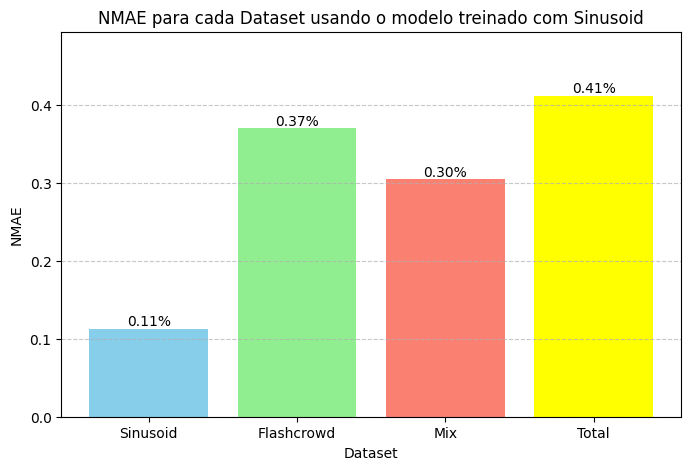

4
4


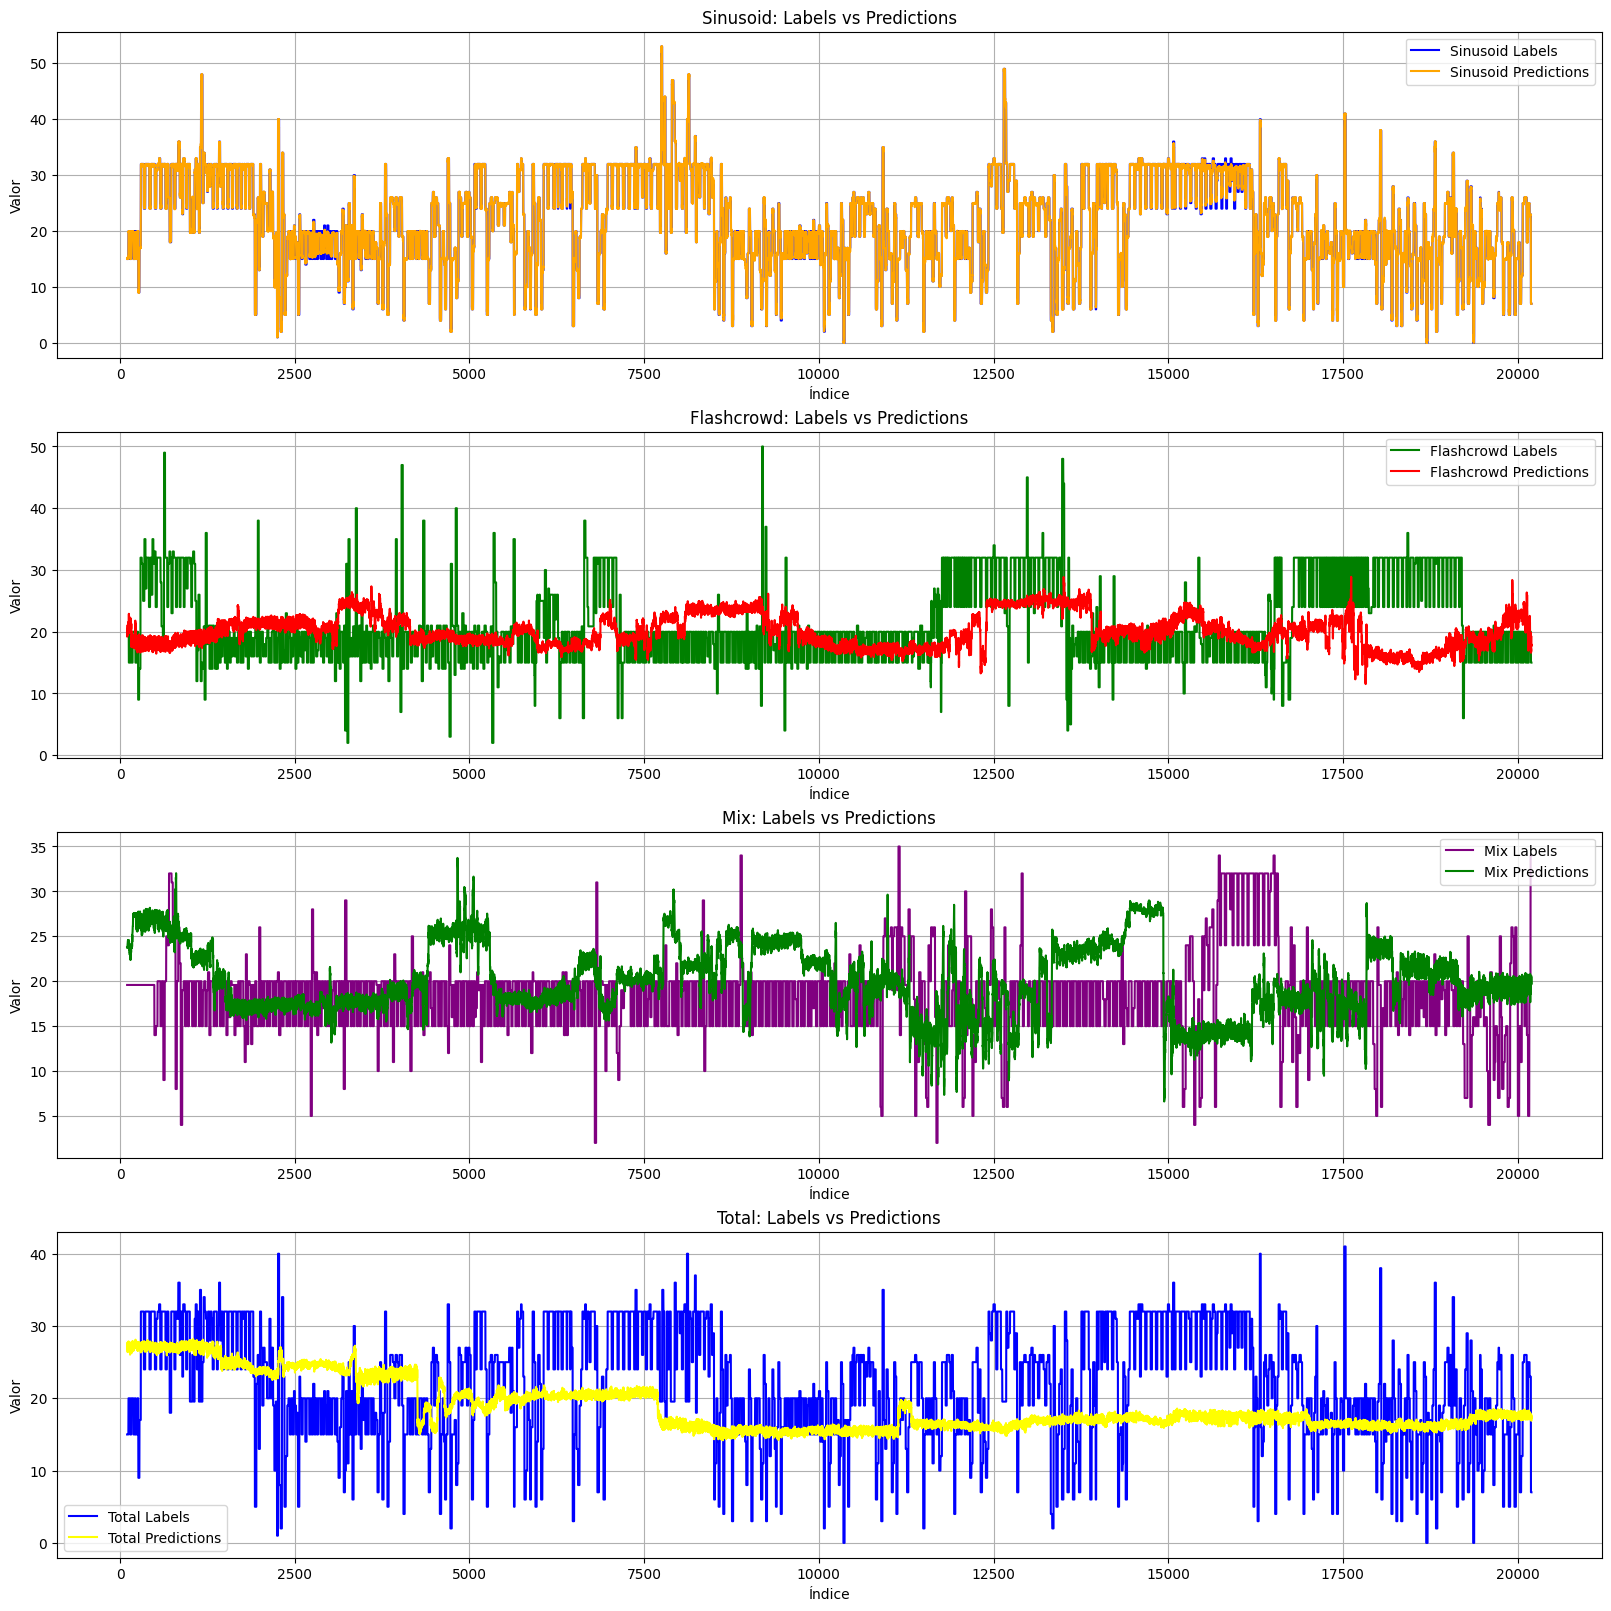

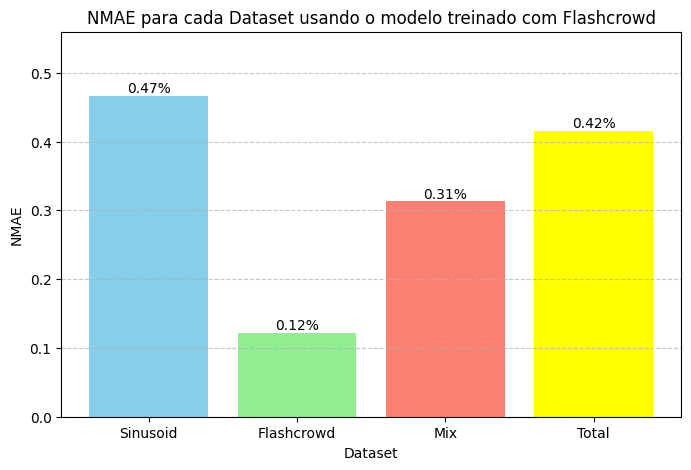

4
4


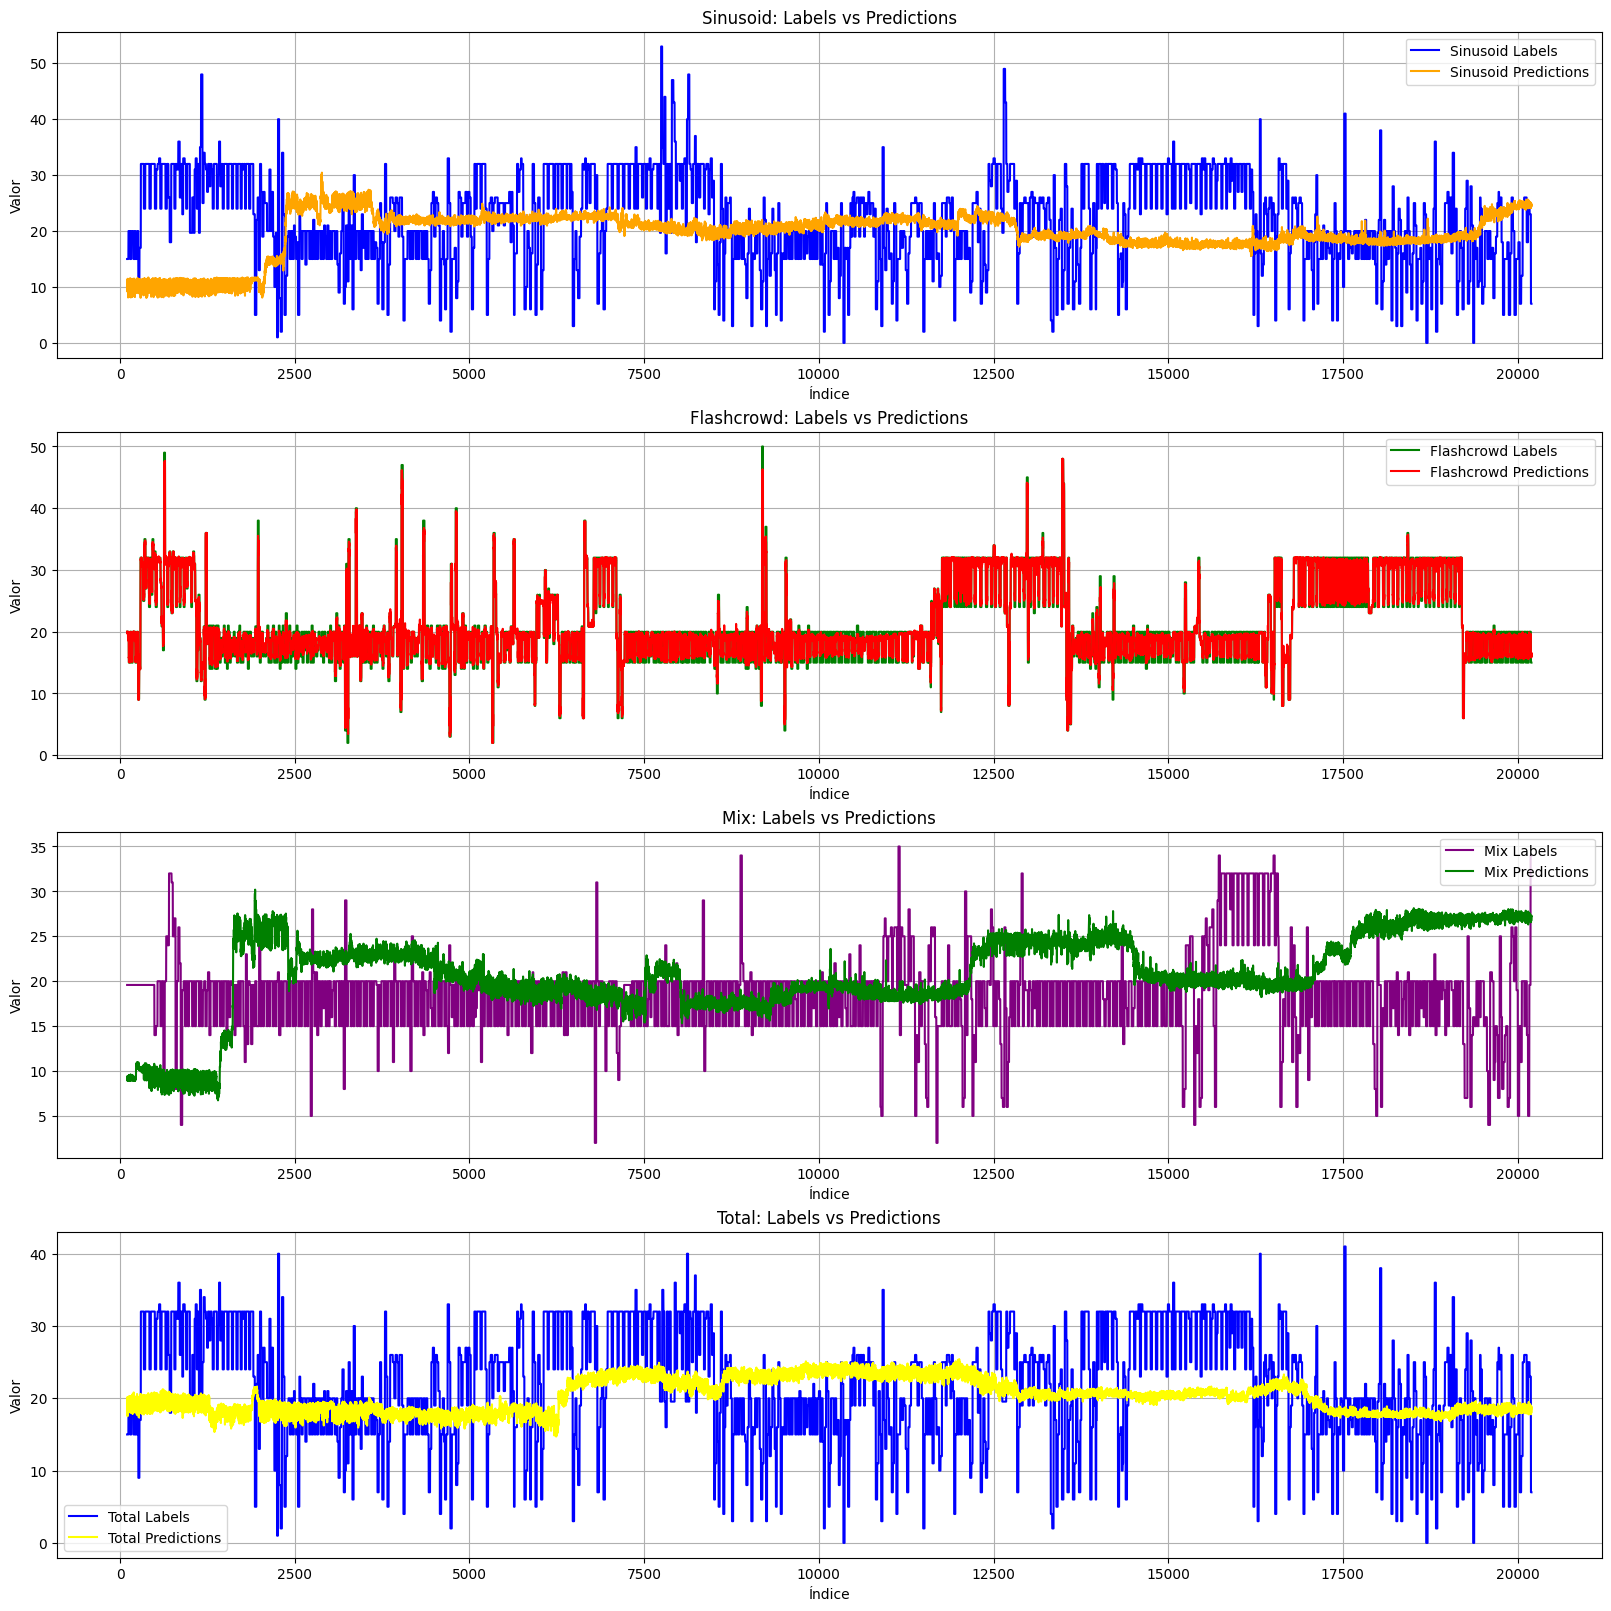

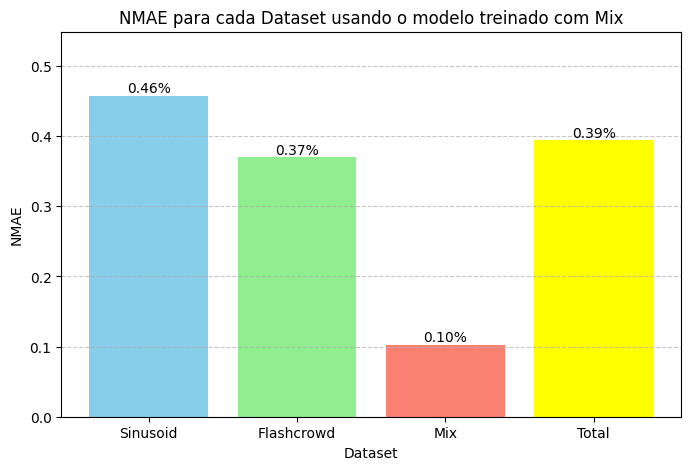

4
4


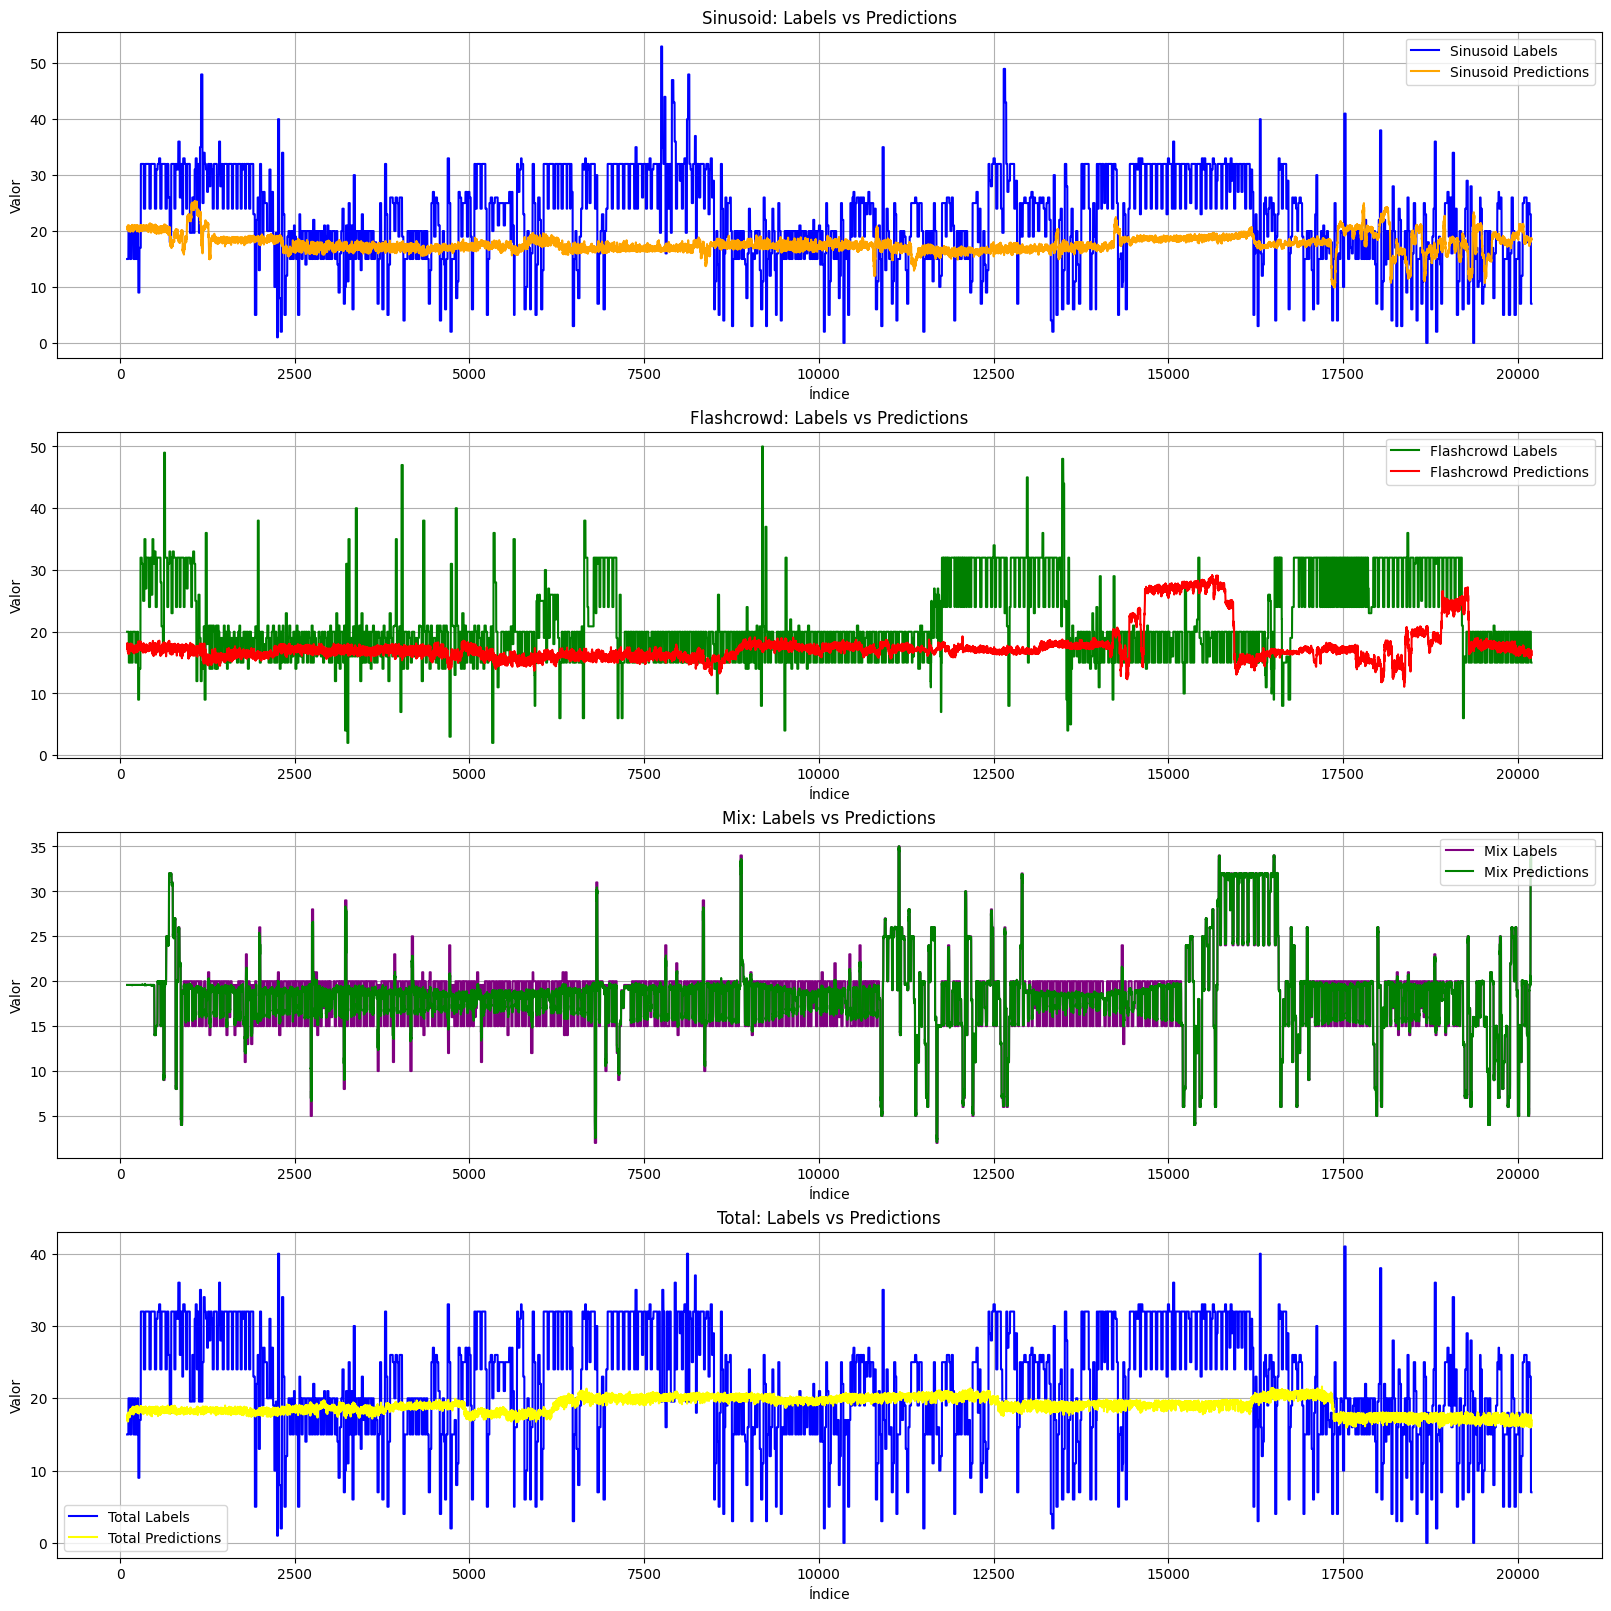

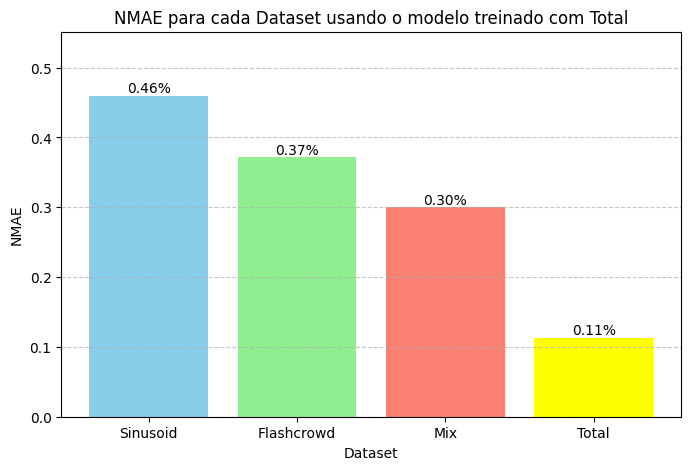

4
4


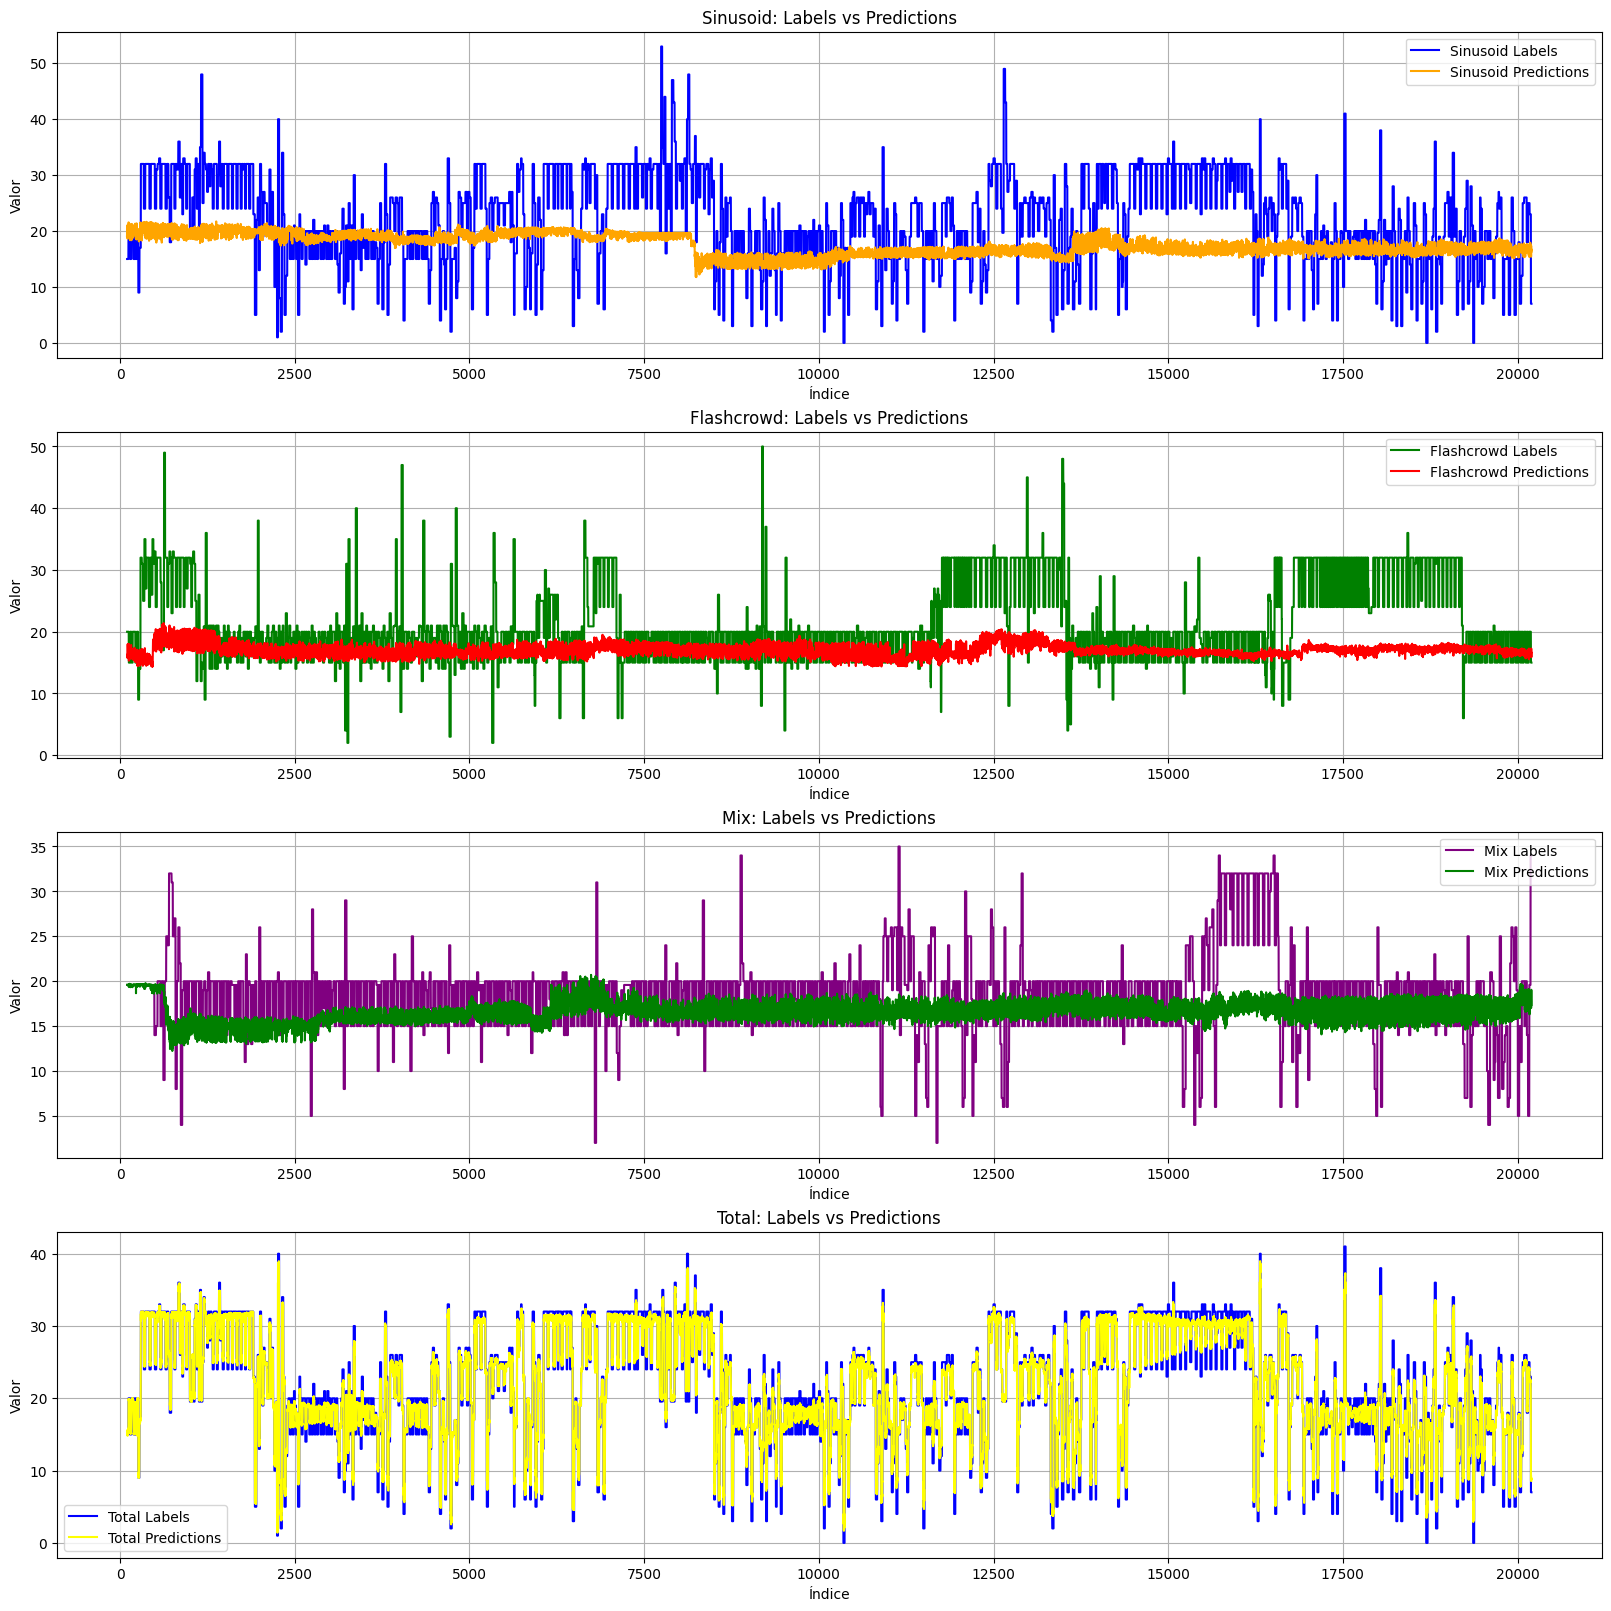

In [19]:
datasets = ['Sinusoid', 'Flashcrowd', 'Mix', 'Total']
model_names = ['Sinusoid', 'Flashcrowd', 'Mix', 'Total']
models = [model_sinusoid, model_flashcrowd, model_mix, model_total]

features_list = [features_sinusoid, features_flashcrowd, features_mix, features_total]
labels_list = [labels_sinusoid, labels_flashcrowd, labels_mix, labels_total]

for model, model_name in zip(models, model_names):
    predictions = [model.predict(features) for features in features_list]
    nmae_values = [nmae(labels, pred) for labels, pred in zip(labels_list, predictions)]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(datasets, nmae_values, color=['skyblue', 'lightgreen', 'salmon', 'yellow'])
    plt.title(f'NMAE para cada Dataset usando o modelo treinado com {model_name}')
    plt.xlabel('Dataset')
    plt.ylabel('NMAE')
    plt.ylim(0, max(nmae_values) * 1.2)

    for bar, value in zip(bars, nmae_values):
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height(),               
            f'{value:.2f}%',               
            ha='center', va='bottom'            
        )
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    plt.show()  

    plot_predictions_comparison(
        start_graph=100, 
        end_graph=20200, 
        labels_list=[labels_sinusoid, labels_flashcrowd, labels_mix, labels_total],
        predictions_list=predictions,
        model_name=model_name
    )
